# Data Cleaning:

In [1]:
# Data processing
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Null imputation using advanced statistical methods
# -----------------------------------------------------------------------
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

# Visualization
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None) # allows you to see the complete columns

In [2]:
# We bring the .csv that we join in the EDA

df = pd.read_csv("../data/merged_customer_data.csv")
df.head(1)

,Loyalty Number,Year,Month,Flights Booked,Flights with Companions,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed,Country,Province,City,Postal Code,Gender,Education,Salary,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Year,Enrollment Month,Cancellation Year,Cancellation Month
0,100018,2017,1,3,0,3,1521,152.0,0,0,Canada,Alberta,Edmonton,T9G 1W3,Female,Bachelor,92552.0,Married,Aurora,7919.2,Standard,2016,8,NaN,NaN


In [3]:
# Before cleaning up, 
# let's analyze the nulls we have, specifically those of `salary` since we have determined that we will set the nulls of the other two columns to 0.

# Let's remember which of the numerical columns had nulls.
nulls = round(df.isnull().sum() / df.shape[0] * 100,2)
nulls = nulls[nulls > 0]
print(f"The numeric columns that have nulls are:\n{nulls} ")
print("______________________________________________")



The numeric columns that have nulls are:
Salary                25.31
Cancellation Year     87.66
Cancellation Month    87.66
dtype: float64 
______________________________________________


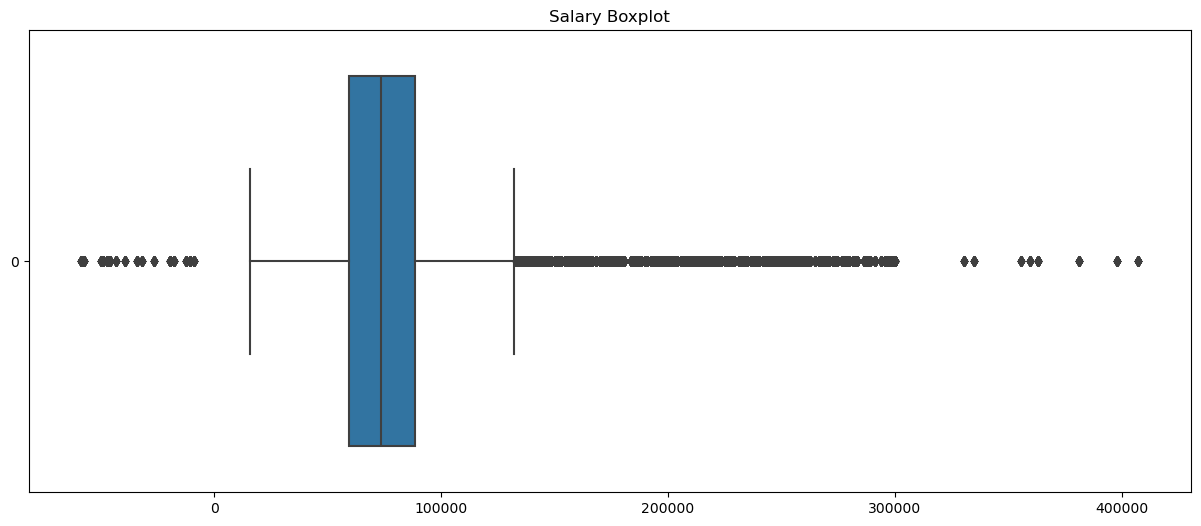

In [4]:
# To see in more detail the values of `salary` we make a boxplot.

plt.figure(figsize=(15, 6))
sns.boxplot(data=df['Salary'], orient='h')
plt.title('Salary Boxplot')
plt.show()

In [5]:
'''
We see that we have a lot of outliers, so we will test between the InterativeImputer and KNNImputer methods to compare them 
and determine which one we are more interested in.

IMPORTANT: after seeing that the KNNImputer method took so long, I have discarded the comparisons.

I take another road. Since we are asked to look at whether there is a relationship between salary and education, 
we will group the two to see which have nulls.
'''
# We create a variable to contain the nulls grouped according to their educational level.
nulls_per_education = df[df['Salary'].isnull()].groupby('Education').size()
print(f"Education level with null is:\n{nulls_per_education}")
print("_________________________________________")
print("Non null averages")
print("_________________________________________")
print(df.groupby('Education')['Salary'].mean())



Education level with null is:
Education
College    102672
dtype: int64
_________________________________________
Non null averages
_________________________________________
Education
Bachelor                 72476.211860
College                           NaN
Doctor                  178335.439516
High School or Below     60986.544192
Master                  103767.494163
Name: Salary, dtype: float64


In [6]:
# Because College and Bachelor's degrees are similar, we will impute based on the mean or median of the Bachelor's degree.

mean_salary_bachelor = df[df['Education'] == 'Bachelor']['Salary'].mean()
median_salary_bachelor = df[df['Education'] == 'Bachelor']['Salary'].median()
print(f"Mean Salary for Bachelor: {mean_salary_bachelor}")
print(f"Median Salary for Bachelor: {median_salary_bachelor}")


Mean Salary for Bachelor: 72476.21186039913
Median Salary for Bachelor: 71971.0


In [7]:
# We see that there is not much difference between the mean and the median, but we will impute by the median to have more robust data.
df.loc[(df['Education'] == 'College') & (df['Salary'].isnull()), 'Salary'] = median_salary_bachelor

print(f"Number of null values in 'Salary' after imputation: {df['Salary'].isnull().sum()}")

Number of null values in 'Salary' after imputation: 0


In [11]:
def normalize_columns(df):
    '''
    Function to normalize column names.
    To do this we create a dictionary which we tell its key to lowercase with the .lower method and change the blanks to '_',iterating through each key in the dictionary to do so.

    Then with the .rename method we rename them and make sure that the df is updated using the inplace=True.
    '''
    new_columns = {column: column.lower().replace(" ", "_") for column in df.columns}
    df.rename(columns = new_columns, inplace = True)
    return df

def normalize_negative(df, column_name):
    '''
    Converts the values of the specified column in the DataFrame to absolute values thus eliminating the negative value of the column 
    using the .abs method. 
    '''
    if column_name in df.columns:
        df[column_name] = df[column_name].abs()
        print(f"The unique values of the column are now: {df[column_name].unique()}. There are no negatives left.")
    else:
        print(f"Column '{column_name}' not found in DataFrame.")

def null_to_0(df, year_col='cancellation_year', month_col='cancellation_month'):
    '''
    This function converts the nulls of the corresponding columns into zeros.
    '''
    if year_col in df.columns:
        df[year_col].fillna(0, inplace=True)
    if month_col in df.columns:
        df[month_col].fillna(0, inplace=True)
    return df
    
def delete_drop(df):
    '''
    Function to remove duplicates and columns that I have already determined I am not interested in.
    '''
    df.drop_duplicates(inplace=True)
    df.drop(['country'], axis=1, inplace=True)
    return print(f"Columns are now: {df.columns},  and there are {df.duplicated().sum()} duplicates")

def clean_fuctions(df):
    '''
    Function to execute all the previous functions without having to call them one by one.

    The order of execution is important.
    '''
    df = normalize_columns(df)
    normalize_negative(df, 'salary')
    df = null_to_0(df)
    df = delete_drop(df)
    return print("All functions have been executed.")
   

In [12]:
clean_fuctions(df)

The unique values of the column are now: [92552. 71971. 63253. ... 23160. 97206. 56345.]. There are no negatives left.
Columns are now: Index(['loyalty_number', 'year', 'month', 'flights_booked',
       'flights_with_companions', 'total_flights', 'distance',
       'points_accumulated', 'points_redeemed', 'dollar_cost_points_redeemed',
       'province', 'city', 'postal_code', 'gender', 'education', 'salary',
       'marital_status', 'loyalty_card', 'clv', 'enrollment_type',
       'enrollment_year', 'enrollment_month', 'cancellation_year',
       'cancellation_month'],
      dtype='object'),  and there are 0 duplicates
All functions have been executed.


In [14]:
# Again, we return the fidelity number as index and check the DataFrame.

df = df.set_index('loyalty_number')
df

,year,month,flights_booked,flights_with_companions,total_flights,distance,points_accumulated,points_redeemed,dollar_cost_points_redeemed,province,city,postal_code,gender,education,salary,marital_status,loyalty_card,clv,enrollment_type,enrollment_year,enrollment_month,cancellation_year,cancellation_month
loyalty_number,,,,,,,,,,,,,,,,,,,,,,,
100018,2017,1,3,0,3,1521,152.0,0,0,Alberta,Edmonton,T9G 1W3,Female,Bachelor,92552.0,Married,Aurora,7919.20,Standard,2016,8,0.0,0.0
100018,2017,2,2,2,4,1320,132.0,0,0,Alberta,Edmonton,T9G 1W3,Female,Bachelor,92552.0,Married,Aurora,7919.20,Standard,2016,8,0.0,0.0
100018,2018,10,6,4,10,3110,311.0,385,31,Alberta,Edmonton,T9G 1W3,Female,Bachelor,92552.0,Married,Aurora,7919.20,Standard,2016,8,0.0,0.0
100018,2017,4,4,0,4,924,92.0,0,0,Alberta,Edmonton,T9G 1W3,Female,Bachelor,92552.0,Married,Aurora,7919.20,Standard,2016,8,0.0,0.0
100018,2017,5,0,0,0,0,0.0,0,0,Alberta,Edmonton,T9G 1W3,Female,Bachelor,92552.0,Married,Aurora,7919.20,Standard,2016,8,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999891,2018,8,0,0,0,0,0.0,0,0,Nova Scotia,Halifax,B3J 9S2,Female,Bachelor,75616.0,Married,Nova,3745.37,Standard,2016,5,2017.0,1.0
999891,2018,9,0,0,0,0,0.0,0,0,Nova Scotia,Halifax,B3J 9S2,Female,Bachelor,75616.0,Married,Nova,3745.37,Standard,2016,5,2017.0,1.0
999891,2018,10,0,0,0,0,0.0,0,0,Nova Scotia,Halifax,B3J 9S2,Female,Bachelor,75616.0,Married,Nova,3745.37,Standard,2016,5,2017.0,1.0


In [15]:
# Save .csv

df.to_csv('../data/clean_customer_data.csv')
print("The clean CSV file has been saved as 'clean_customer_data.csv'")

The clean CSV file has been saved as 'clean_customer_data.csv'
